In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from scipy.stats import ttest_ind, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
from tqdm import tqdm

In [206]:
# Генерируем две случайные выборки с биномиальным распределением, которые принадлежат одной генеральной совокупности.
# Проводим Z-тест. P-value должно быть близкое к единице т.к. выборки принадлежат одной совокупности.
# Повторяем 1000 раз, смотрим какая доля тестов с P-value менее 0.05

In [207]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 1000)
    b = np.random.binomial(1, 0.03, 1000)
    p_value = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])[1]
    result.append(p_value)
result = pd.Series(result)
print((result < 0.05).mean())

100%|██████████| 1000/1000 [00:00<00:00, 4002.39it/s]

0.056


In [208]:
# Видим, что доля тестов с P-value <= 0.05 около 5%. Значит в 5% случаев тест находит разницу там, где ее на самом деле нет.
# Или можно сказать, что тест в 95% верно определяет, что разницы нет. Такая вероятность в статистике определяется значением параметра alpha.
# Например, если alpha = 0.05 мы принимаем погрешность, что 5% случаев мы будем отвергать верную нулевую гипотезу.

<AxesSubplot:>

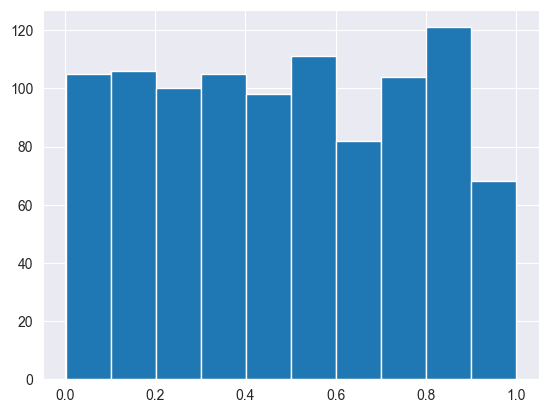

In [209]:
# Построим гистограмму распределения P-value
result.hist()

In [210]:
# Изменим условия. Смоделируем ситуацию, когда выборки не принадлежат одной генеральной совокупности.
# Посмотрим, какая доля тестов будет с P-value > 0.05.

In [211]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 1000)
    b = np.random.binomial(1, 0.035, 1000)
    p_value = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])[1]
    result.append(p_value)
result = pd.Series(result)
print((result >= 0.05).mean())

100%|██████████| 1000/1000 [00:00<00:00, 3753.81it/s]

0.914


In [212]:
# Тест в 90% случаев показывает, что выборки принадлежат одной генеральной совокупности, хотя это не так. Такая ситуация в статистике называется
# ошибка второго рода, когда мы принимаем неверную нулевую гипотезу. Можно переформулировать, что мы не смогли обнаружить отличия там где они есть.
# Параметр, который отвечает за вероятность найти отличия в ситуации когда они есть называется мощность. В нашем случае он равен 10%, что очень мало.
# Предположим, что тест не может определить изменение в 0.5 процентных пункта на выборках в 1000 наблюдений.

In [213]:
# Изменим условия теста: увеличим размер выборки до 10 000 наблюдений, P-value <= 0.05

In [214]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 10000)
    b = np.random.binomial(1, 0.035, 10000)
    p_value = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])[1]
    result.append(p_value)
result = pd.Series(result)
print((result < 0.05).mean())

100%|██████████| 1000/1000 [00:00<00:00, 1761.94it/s]

0.546


In [215]:
# Уже лучше. Тест дает ложноположительный результат примерно в 50% случаев. Увеличиваем размер выборки до 20 000 наблюдений.

In [216]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 20000)
    b = np.random.binomial(1, 0.035, 20000)
    p_value = proportions_ztest([a.sum(), b.sum()], [len(a), len(b)])[1]
    result.append(p_value)
result = pd.Series(result)
print((result < 0.05).mean())

100%|██████████| 1000/1000 [00:00<00:00, 1210.62it/s]

0.833


In [217]:
# Тест верно определяет разницу между выборками в 80% случаев. Что же неплохо. В статистике power=80% считается приемлемым.

<AxesSubplot:>

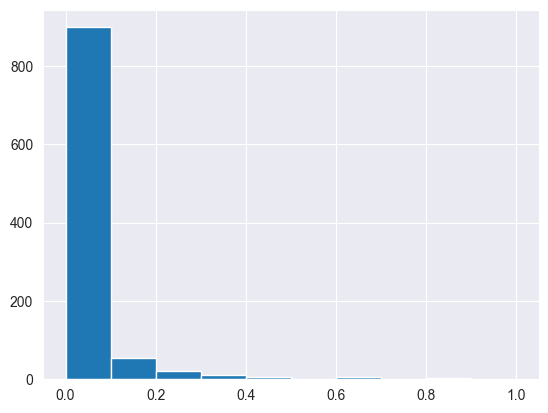

In [218]:
# Построим гистограмму распределения
result.hist()

In [219]:
# Итак, методом тыка мы нашли необходимый размер выборки в 20 000 наблюдений. Вывод: размер выборки влияет на точность теста.
# Попробуем более научный подход определения размера выборки. Для этого используем statsmodels.stats.power. NormalIndPower.solve_power
# Тест на вход принимает параметры: ожидаемое изменение, размер контрольной выборки, alpha, power, соотношение контрольной и тестовой групп,
# тип теста: меньше, больше или двухсторонний. Тест возвращает параметр, который не определен. Например, нам нужно узнать размер выборки.
# Не будет его указывать.

In [220]:
es = sms.proportion_effectsize(0.03, 0.035)
sample_size = round(sms.NormalIndPower().solve_power(es, power=0.80, alpha=0.05, ratio=1))
print(es)
print(sample_size)

-0.02821746104476741
19715


In [221]:
# Для генерации выборок мы использовали биномиальное распределение, для вычисления P-value использовали Z-тест.
# Попробуем другие тесты.

In [222]:
# Первый в нашей очереди T-тест. Используем ttest_ind из библиотеки scipy.stats. Тест принимает параметры: a, b это две выборки,
# которые содержат положительные и отрицательные результаты, в нашем случае массив из нулей и единиц [1, 0, 0, 0, 1], equal_var — по умолчанию False.
# False — выборки принадлежат одной генеральной совокупности с одинаковой дисперсией, используется обычный T-тест, True — выборки принадлежат
# разным генеральным совокупностям, используется T-тест Уэлча.
# !!! Обрати внимание, equal_var=False

In [223]:
result = []
a_st_dev = []
b_st_dev = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 19715)
    a_st_dev.append(np.std(a))
    b = np.random.binomial(1, 0.03, 19715)
    b_st_dev.append(np.std(b))
    p_value = ttest_ind(a, b, equal_var=False)[1]
    result.append(p_value)
a_result = pd.Series(a_st_dev)
b_result = pd.Series(b_st_dev)
result = pd.Series(result)
print('Среднее стандартное отклонение для группы A:', a_result.mean())
print('Среднее стандартное отклонение для группы B:', b_result.mean())
print('alpha=', (result < 0.05).mean(), sep='')

100%|██████████| 1000/1000 [00:01<00:00, 672.62it/s]

Среднее стандартное отклонение для группы A: 0.17052783085073167
Среднее стандартное отклонение для группы B: 0.17046655845158382
alpha=0.054


<AxesSubplot:>

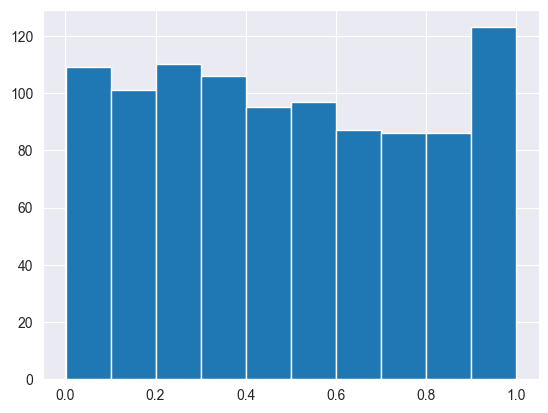

In [224]:
result.hist()

In [225]:
result = []
a_st_dev = []
b_st_dev = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 19715)
    a_st_dev.append(np.std(a))
    b = np.random.binomial(1, 0.035, 19715)
    b_st_dev.append(np.std(b))
    p_value = ttest_ind(a, b, equal_var=True)[1]
    result.append(p_value)
a_result = pd.Series(a_st_dev)
b_result = pd.Series(b_st_dev)
result = pd.Series(result)
print('Среднее стандартное отклонение для группы A:', a_result.mean())
print('Среднее стандартное отклонение для группы B:', b_result.mean())
print('power=', (result < 0.05).mean(), sep='')

100%|██████████| 1000/1000 [00:01<00:00, 729.53it/s]

Среднее стандартное отклонение для группы A: 0.1704797019821507
Среднее стандартное отклонение для группы B: 0.1837688023221973
power=0.808


<AxesSubplot:>

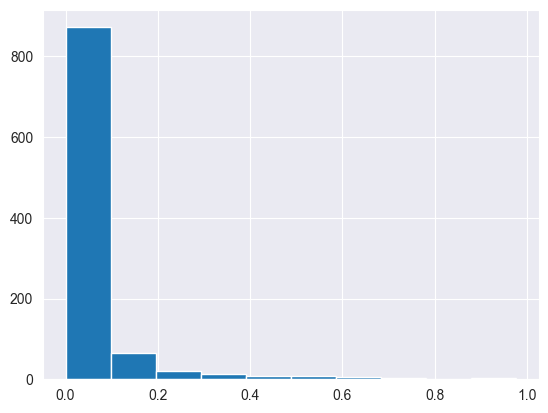

In [226]:
result.hist()

In [227]:
# Вывод T-тест дает схожие показатели alpha и power, распределение P-value

In [228]:
# Для разнообразия попробуем непараметрический U-тест Манна-Уитни. Он хорош для малых выборок или когда есть значительные выбросы (высокая дисперсия)
# или для анализа непрерывных переменных

In [229]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 19715)
    b = np.random.binomial(1, 0.03, 19715)
    p_value = mannwhitneyu(a, b)[1]
    result.append(p_value)
result = pd.Series(result)
print('alpha=', (result < 0.05).mean(), sep='')

100%|██████████| 1000/1000 [00:25<00:00, 38.95it/s]

alpha=0.059


In [230]:
result = []
for _ in tqdm(range(1000)):
    a = np.random.binomial(1, 0.03, 19715)
    b = np.random.binomial(1, 0.035, 19715)
    p_value = mannwhitneyu(a, b)[1]
    result.append(p_value)
result = pd.Series(result)
print('power=', (result < 0.05).mean(), sep='')

100%|██████████| 1000/1000 [00:24<00:00, 40.28it/s]

power=0.804


In [ ]:
# Манн-Уитни дал схожие результаты.